# Image Super-Resolution using an Efficient Sub-Pixel CNN

**Author:** [Xingyu Long](https://github.com/xingyu-long)<br>
**Date created:** 2020/07/28<br>
**Last modified:** 2020/08/27<br>
**Description:** Implementing Super-Resolution using Efficient sub-pixel model on BSDS500.

## Introduction

ESPCN (Efficient Sub-Pixel CNN), proposed by [Shi, 2016](https://arxiv.org/abs/1609.05158)
is a model that reconstructs a high-resolution version of an image given a low-resolution version.
It leverages efficient "sub-pixel convolution" layers, which learns an array of
image upscaling filters.

In this code example, we will implement the model from the paper and train it on a small dataset,
[BSDS500](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/resources.html).

## Setup

In [23]:
import tensorflow as tf

import os
import math
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

from IPython.display import display

## Load data: BSDS500 dataset

### Download dataset

We use the built-in `keras.utils.get_file` utility to retrieve the dataset.

In [24]:
dataset_url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
data_dir = keras.utils.get_file(origin=dataset_url, fname="BSR", untar=True)
root_dir = os.path.join(data_dir, "BSDS500/data")

We create training and validation datasets via `image_dataset_from_directory`.

In [25]:
crop_size = 300
upscale_factor = 3
input_size = crop_size // upscale_factor
batch_size = 32

train_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,
)

valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,
)

Found 500 files belonging to 1 classes.
Using 400 files for training.
Found 500 files belonging to 1 classes.
Using 100 files for validation.


We rescale the images to take values in the range [0, 1].

In [26]:

def scaling(input_image):
    input_image = input_image / 255.0
    return input_image


# Scale from (0, 255) to (0, 1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

Let's visualize a few sample images:

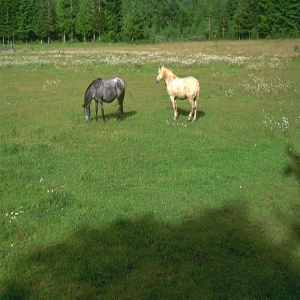

In [27]:
for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img))
        break
    break

We prepare a dataset of test image paths that we will use for
visual evaluation at the end of this example.

In [6]:
dataset = os.path.join(root_dir, "images")
test_path = os.path.join(dataset, "test")

test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".jpg")
    ]
)

## Crop and resize images

Let's process image data.
First, we convert our images from the RGB color space to the
[YUV colour space](https://en.wikipedia.org/wiki/YUV).

For the input data (low-resolution images),
we crop the image, retrieve the `y` channel (luninance),
and resize it with the `area` method (use `BICUBIC` if you use PIL).
We only consider the luminance channel
in the YUV color space because humans are more sensitive to
luminance change.

For the target data (high-resolution images), we just crop the image
and retrieve the `y` channel.

In [7]:

# Use TF Ops to process.
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)

Let's take a look at the input and target data.

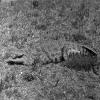

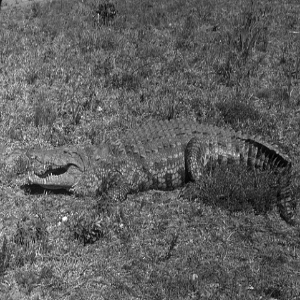

In [20]:
for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))
        break
    for img in batch[1]:
        display(array_to_img(img))
        break

## Build a model

Compared to the paper, we add one more layer and we use the `relu` activation function
instead of `tanh`.
It achieves better performance even though we train the model for fewer epochs.

Note: `swish` is a "better version of relu".

In [9]:

def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)


## Define utility functions

We need to define several utility functions to monitor our results:

- `plot_results` to plot an save an image.
- `get_lowres_image` to convert an image to its low-resolution version.
- `upscale_image` to turn a low-resolution image to
a high-resolution version reconstructed by the model.
In this function, we use the `y` channel from the YUV color space
as input to the model and then combine the output with the
other channels to obtain an RGB image.

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img


## Define callbacks to monitor training

The `ESPCNCallback` object will compute and display
the [PSNR](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio) metric.
This is the main metric we use to evaluate super-resolution performance.

In [11]:
def psnr(loss):
    return 10 * math.log10(1 / loss)

class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(psnr(logs["loss"]))
        


Define `ModelCheckpoint` and `EarlyStopping` callbacks.

In [12]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=20, restore_best_weights=True, min_delta=0.000005)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback]
loss_fn = keras.losses.MeanSquaredError()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 64)    1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 9)     2601      
_________________________________________________________________
tf.nn.depth_to_space (TFOpLa (None, None, None, 1)     0         
Total params: 59,657
Trainable params: 59,657
Non-trainable params: 0
_________________________________________________________

## Train the model

Epoch 1/500
13/13 - 3s - loss: 0.1052 - val_loss: 0.0643
Mean PSNR for epoch: 11.97


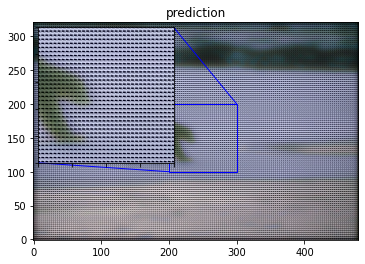

Epoch 2/500
13/13 - 1s - loss: 0.0450 - val_loss: 0.0298
Mean PSNR for epoch: 15.24
Epoch 3/500
13/13 - 1s - loss: 0.0142 - val_loss: 0.0087
Mean PSNR for epoch: 20.65
Epoch 4/500
13/13 - 1s - loss: 0.0078 - val_loss: 0.0062
Mean PSNR for epoch: 22.09
Epoch 5/500
13/13 - 1s - loss: 0.0062 - val_loss: 0.0051
Mean PSNR for epoch: 22.99
Epoch 6/500
13/13 - 1s - loss: 0.0053 - val_loss: 0.0043
Mean PSNR for epoch: 23.66
Epoch 7/500
13/13 - 1s - loss: 0.0045 - val_loss: 0.0037
Mean PSNR for epoch: 24.44
Epoch 8/500
13/13 - 1s - loss: 0.0040 - val_loss: 0.0034
Mean PSNR for epoch: 24.66
Epoch 9/500
13/13 - 1s - loss: 0.0037 - val_loss: 0.0032
Mean PSNR for epoch: 24.97
Epoch 10/500
13/13 - 1s - loss: 0.0035 - val_loss: 0.0030
Mean PSNR for epoch: 25.18
Epoch 11/500
13/13 - 1s - loss: 0.0033 - val_loss: 0.0029
Mean PSNR for epoch: 25.45
Epoch 12/500
13/13 - 1s - loss: 0.0032 - val_loss: 0.0029
Mean PSNR for epoch: 25.62
Epoch 13/500
13/13 - 1s - loss: 0.0031 - val_loss: 0.0027
Mean PSNR for e

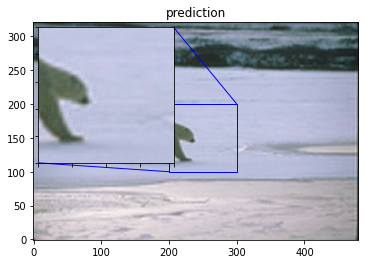

Epoch 22/500
13/13 - 1s - loss: 0.0029 - val_loss: 0.0025
Mean PSNR for epoch: 26.10
Epoch 23/500
13/13 - 1s - loss: 0.0029 - val_loss: 0.0026
Mean PSNR for epoch: 26.06
Epoch 24/500
13/13 - 1s - loss: 0.0029 - val_loss: 0.0025
Mean PSNR for epoch: 26.21
Epoch 25/500
13/13 - 1s - loss: 0.0029 - val_loss: 0.0025
Mean PSNR for epoch: 26.12
Epoch 26/500
13/13 - 1s - loss: 0.0029 - val_loss: 0.0025
Mean PSNR for epoch: 26.13
Epoch 27/500
13/13 - 1s - loss: 0.0028 - val_loss: 0.0025
Mean PSNR for epoch: 26.30
Epoch 28/500
13/13 - 1s - loss: 0.0028 - val_loss: 0.0025
Mean PSNR for epoch: 25.99
Epoch 29/500
13/13 - 1s - loss: 0.0028 - val_loss: 0.0025
Mean PSNR for epoch: 25.99
Epoch 30/500
13/13 - 1s - loss: 0.0028 - val_loss: 0.0025
Mean PSNR for epoch: 26.04
Epoch 31/500
13/13 - 1s - loss: 0.0028 - val_loss: 0.0025
Mean PSNR for epoch: 25.96
Epoch 32/500
13/13 - 1s - loss: 0.0028 - val_loss: 0.0025
Mean PSNR for epoch: 25.85
Epoch 33/500
13/13 - 1s - loss: 0.0029 - val_loss: 0.0025
Mean PS

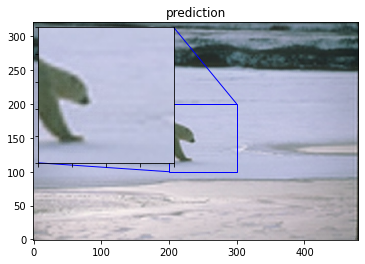

Epoch 42/500
13/13 - 1s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.29
Epoch 43/500
13/13 - 1s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.15
Epoch 44/500
13/13 - 1s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.10
Epoch 45/500
13/13 - 1s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.20
Epoch 46/500
13/13 - 1s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.44
Epoch 47/500
13/13 - 1s - loss: 0.0027 - val_loss: 0.0025
Mean PSNR for epoch: 26.07
Epoch 48/500
13/13 - 1s - loss: 0.0028 - val_loss: 0.0025
Mean PSNR for epoch: 25.98
Epoch 49/500
13/13 - 1s - loss: 0.0028 - val_loss: 0.0025
Mean PSNR for epoch: 25.94
Epoch 50/500
13/13 - 1s - loss: 0.0028 - val_loss: 0.0025
Mean PSNR for epoch: 26.14
Epoch 51/500
13/13 - 1s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.04
Epoch 52/500
13/13 - 1s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.16
Epoch 53/500
13/13 - 1s - loss: 0.0027 - val_loss: 0.0024
Mean PS

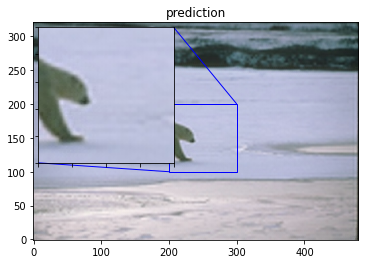

Epoch 62/500
13/13 - 1s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.16
Epoch 63/500
13/13 - 1s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.30
Epoch 64/500
13/13 - 1s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.59
Epoch 65/500
13/13 - 1s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.18
Epoch 66/500
13/13 - 1s - loss: 0.0027 - val_loss: 0.0029
Mean PSNR for epoch: 25.14
Epoch 67/500
13/13 - 1s - loss: 0.0030 - val_loss: 0.0024
Mean PSNR for epoch: 26.02
Epoch 68/500
13/13 - 1s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.23
Epoch 69/500
13/13 - 1s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.32
Epoch 70/500
13/13 - 1s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.20
Epoch 71/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0024
Mean PSNR for epoch: 26.33
Epoch 72/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0024
Mean PSNR for epoch: 26.50
Epoch 73/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0024
Mean PS

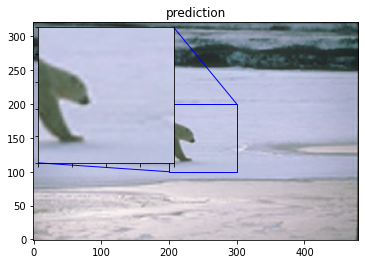

Epoch 82/500
13/13 - 1s - loss: 0.0036 - val_loss: 0.0035
Mean PSNR for epoch: 24.57
Epoch 83/500
13/13 - 1s - loss: 0.0031 - val_loss: 0.0026
Mean PSNR for epoch: 26.01
Epoch 84/500
13/13 - 1s - loss: 0.0028 - val_loss: 0.0024
Mean PSNR for epoch: 26.18
Epoch 85/500
13/13 - 1s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.43
Epoch 86/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0024
Mean PSNR for epoch: 26.43
Epoch 87/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.21
Epoch 88/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.37
Epoch 89/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.29
Epoch 90/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.24
Epoch 91/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.18
Epoch 92/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.20
Epoch 93/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PS

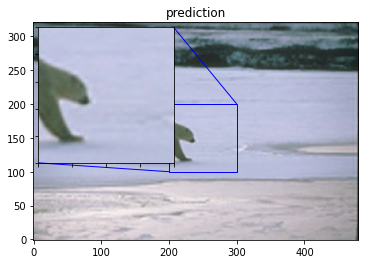

Epoch 102/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.30
Epoch 103/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.37
Epoch 104/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.48
Epoch 105/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.57
Epoch 106/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.78
Epoch 107/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.37
Epoch 108/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.43
Epoch 109/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.35
Epoch 110/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.59
Epoch 111/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.29
Epoch 112/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.42
Epoch 113/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.

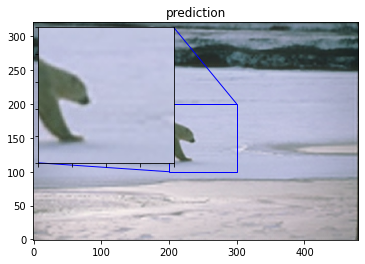

Epoch 122/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.50
Epoch 123/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.57
Epoch 124/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.34
Epoch 125/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.27
Epoch 126/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.39
Epoch 127/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.49
Epoch 128/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.31
Epoch 129/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.71
Epoch 130/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.28
Epoch 131/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.46
Epoch 132/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.34
Epoch 133/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.

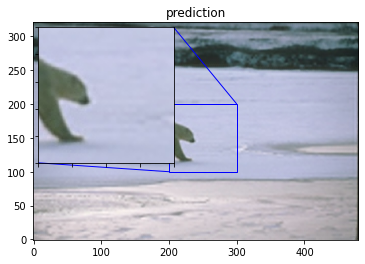

Epoch 142/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.65
Epoch 143/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0024
Mean PSNR for epoch: 26.29
Epoch 144/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.47
Epoch 145/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.07
Epoch 146/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.34
Epoch 147/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.35
Epoch 148/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.40
Epoch 149/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.49
Epoch 150/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.50
Epoch 151/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.56
Epoch 152/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.34
Epoch 153/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.

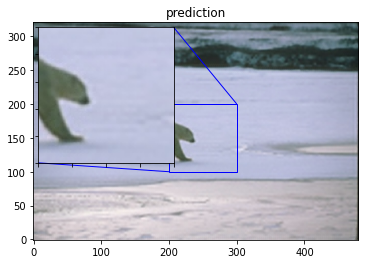

Epoch 162/500
13/13 - 1s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.24
Epoch 163/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.44
Epoch 164/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.40
Epoch 165/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.53
Epoch 166/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.54
Epoch 167/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.76
Epoch 168/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.55
Epoch 169/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.47
Epoch 170/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.65
Epoch 171/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.38
Epoch 172/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.64
Epoch 173/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.

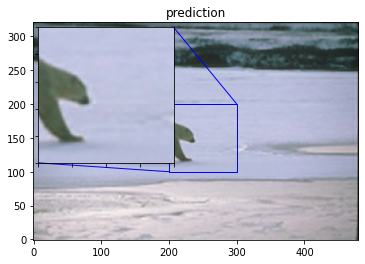

Epoch 182/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.39
Epoch 183/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.45
Epoch 184/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.47
Epoch 185/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.32
Epoch 186/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.39
Epoch 187/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.51
Epoch 188/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.45
Epoch 189/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.55
Epoch 190/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.32
Epoch 191/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.30
Epoch 192/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0024
Mean PSNR for epoch: 26.04
Epoch 193/500
13/13 - 1s - loss: 0.0027 - val_loss: 0.

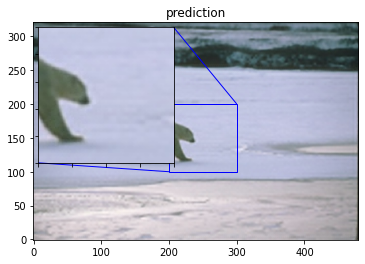

Epoch 202/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.51
Epoch 203/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.64
Epoch 204/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.38
Epoch 205/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.66
Epoch 206/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.28
Epoch 207/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.41
Epoch 208/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.62
Epoch 209/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.45
Epoch 210/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.61
Epoch 211/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.46
Epoch 212/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.53
Epoch 213/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.

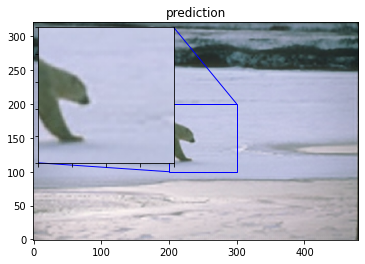

Epoch 222/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.48
Epoch 223/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.80
Epoch 224/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.31
Epoch 225/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.67
Epoch 226/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.46
Epoch 227/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.60
Epoch 228/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.81
Epoch 229/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.77
Epoch 230/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.29
Epoch 231/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.38
Epoch 232/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.80
Epoch 233/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.

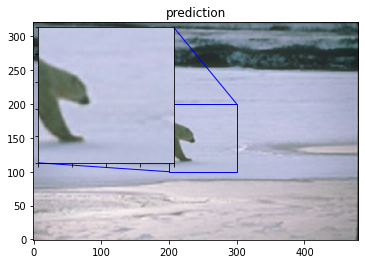

Epoch 242/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.66
Epoch 243/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.73
Epoch 244/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.45
Epoch 245/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.47
Epoch 246/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.62
Epoch 247/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.52
Epoch 248/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.51
Epoch 249/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.85
Epoch 250/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.69
Epoch 251/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.73
Epoch 252/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.32
Epoch 253/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.

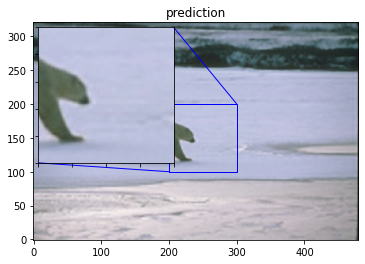

Epoch 262/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.47
Epoch 263/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.55
Epoch 264/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.62
Epoch 265/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.57
Epoch 266/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.50
4/4 [==============================] - 0s 14ms/step - loss: 0.0022
0.002229144796729088
PSNR:  26.518617204932795


In [13]:
epochs = 500

optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer, loss=loss_fn,
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)

loss = model.evaluate(valid_ds)
print(loss)
print('PSNR: ', psnr(loss))

## Run model prediction and plot the results

Let's compute the reconstructed version of a few images and save the results.

PSNR of low resolution image and high resolution image is 29.8502
PSNR of predict and high resolution is 30.3424


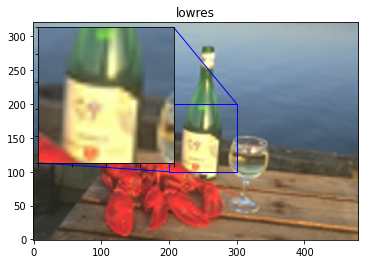

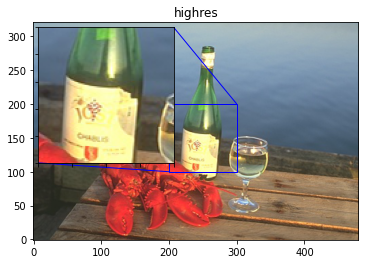

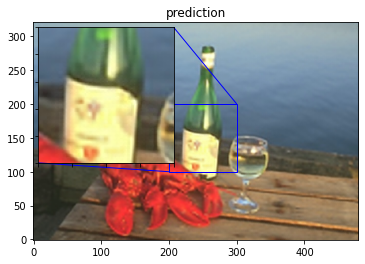

Avg. PSNR of lowres images is 2.9850
Avg. PSNR of reconstructions is 3.0342


In [21]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_paths[50:60]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    )
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")
    break

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))

# WedgeDropout2D

In [15]:
!pip uninstall -y keras-wedge-dropout
!pip install -q git+https://github.com/LanceNorskog/keras-wedge.git
from keras_wedge_dropout import WedgeDropout2D

Found existing installation: keras-wedge-dropout 0.1.0
Uninstalling keras-wedge-dropout-0.1.0:
  Successfully uninstalled keras-wedge-dropout-0.1.0


In [16]:
def get_model_wedge(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    x = WedgeDropout2D(similarity=0.65, batchwise=True)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)

model_wedge = get_model_wedge(upscale_factor=upscale_factor, channels=1)
model.summary()

WedgeDropout2D.build: input_shape: (None, None, None, 9)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 64)    1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 9)     2601      
_________________________________________________________________
tf.nn.depth_to_space (TFOpLa (None, None, None, 1)     0         
Total params: 59,657
Trainable params: 59,657
Non-trainable params: 0


Epoch 1/500
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
13/13 - 2s - loss: 0.0813 - val_loss: 0.0346
Mean PSNR for epoch: 14.71


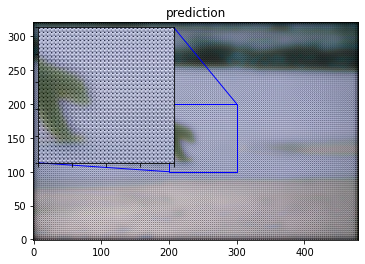

Epoch 2/500
13/13 - 1s - loss: 0.0188 - val_loss: 0.0125
Mean PSNR for epoch: 19.06
Epoch 3/500
13/13 - 1s - loss: 0.0101 - val_loss: 0.0077
Mean PSNR for epoch: 21.33
Epoch 4/500
13/13 - 1s - loss: 0.0076 - val_loss: 0.0062
Mean PSNR for epoch: 21.91
Epoch 5/500
13/13 - 1s - loss: 0.0063 - val_loss: 0.0052
Mean PSNR for epoch: 22.83
Epoch 6/500
13/13 - 1s - loss: 0.0055 - val_loss: 0.0046
Mean PSNR for epoch: 23.20
Epoch 7/500
13/13 - 1s - loss: 0.0048 - val_loss: 0.0040
Mean PSNR for epoch: 24.09
Epoch 8/500
13/13 - 1s - loss: 0.0043 - val_loss: 0.0035
Mean PSNR for epoch: 24.43
Epoch 9/500
13/13 - 1s - loss: 0.0038 - val_loss: 0.0033
Mean PSNR for epoch: 24.75
Epoch 10/500
13/13 - 1s - loss: 0.0036 - val_loss: 0.0031
Mean PSNR for epoch: 25.20
Epoch 11/500
13/13 - 1s - loss: 0.0034 - val_loss: 0.0029
Mean PSNR for epoch: 25.30
Epoch 12/500
13/13 - 1s - loss: 0.0033 - val_loss: 0.0028
Mean PSNR for epoch: 25.39
Epoch 13/500
13/13 - 1s - loss: 0.0034 - val_loss: 0.0038
Mean PSNR for e

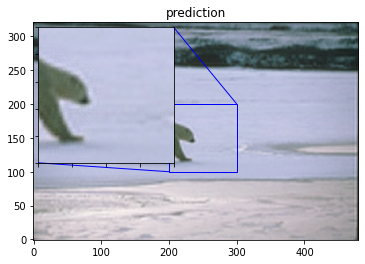

Epoch 22/500
13/13 - 1s - loss: 0.0029 - val_loss: 0.0026
Mean PSNR for epoch: 25.90
Epoch 23/500
13/13 - 1s - loss: 0.0029 - val_loss: 0.0026
Mean PSNR for epoch: 25.96
Epoch 24/500
13/13 - 1s - loss: 0.0029 - val_loss: 0.0025
Mean PSNR for epoch: 25.90
Epoch 25/500
13/13 - 1s - loss: 0.0028 - val_loss: 0.0025
Mean PSNR for epoch: 25.85
Epoch 26/500
13/13 - 1s - loss: 0.0028 - val_loss: 0.0025
Mean PSNR for epoch: 26.14
Epoch 27/500
13/13 - 1s - loss: 0.0028 - val_loss: 0.0028
Mean PSNR for epoch: 25.49
Epoch 28/500
13/13 - 1s - loss: 0.0029 - val_loss: 0.0026
Mean PSNR for epoch: 25.76
Epoch 29/500
13/13 - 1s - loss: 0.0028 - val_loss: 0.0025
Mean PSNR for epoch: 26.10
Epoch 30/500
13/13 - 1s - loss: 0.0028 - val_loss: 0.0025
Mean PSNR for epoch: 26.07
Epoch 31/500
13/13 - 1s - loss: 0.0028 - val_loss: 0.0025
Mean PSNR for epoch: 26.06
Epoch 32/500
13/13 - 1s - loss: 0.0028 - val_loss: 0.0025
Mean PSNR for epoch: 26.14
Epoch 33/500
13/13 - 1s - loss: 0.0028 - val_loss: 0.0025
Mean PS

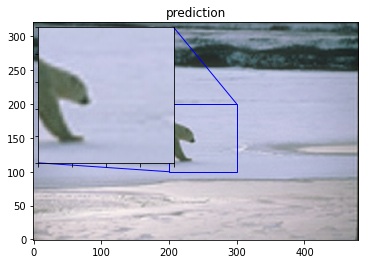

Epoch 42/500
13/13 - 1s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.38
Epoch 43/500
13/13 - 1s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.18
Epoch 44/500
13/13 - 1s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.29
Epoch 45/500
13/13 - 1s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.26
Epoch 46/500
13/13 - 1s - loss: 0.0027 - val_loss: 0.0028
Mean PSNR for epoch: 25.39
Epoch 47/500
13/13 - 1s - loss: 0.0029 - val_loss: 0.0026
Mean PSNR for epoch: 26.01
Epoch 48/500
13/13 - 1s - loss: 0.0028 - val_loss: 0.0024
Mean PSNR for epoch: 26.15
Epoch 49/500
13/13 - 1s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.05
Epoch 50/500
13/13 - 1s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.46
Epoch 51/500
13/13 - 1s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.10
Epoch 52/500
13/13 - 1s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.16
Epoch 53/500
13/13 - 1s - loss: 0.0027 - val_loss: 0.0024
Mean PS

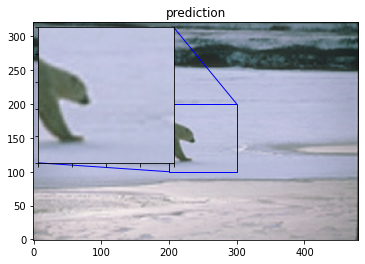

Epoch 62/500
13/13 - 1s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.46
Epoch 63/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0024
Mean PSNR for epoch: 26.18
Epoch 64/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0024
Mean PSNR for epoch: 26.35
Epoch 65/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0024
Mean PSNR for epoch: 26.25
Epoch 66/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.28
Epoch 67/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0025
Mean PSNR for epoch: 26.06
Epoch 68/500
13/13 - 1s - loss: 0.0027 - val_loss: 0.0023
Mean PSNR for epoch: 26.26
Epoch 69/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0024
Mean PSNR for epoch: 26.25
Epoch 70/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.49
Epoch 71/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0024
Mean PSNR for epoch: 26.22
Epoch 72/500
13/13 - 1s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.26
Epoch 73/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PS

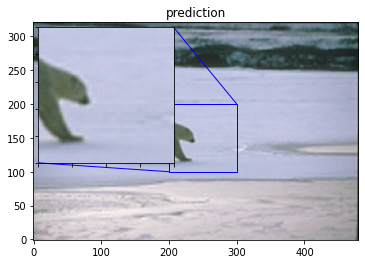

Epoch 82/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.25
Epoch 83/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.50
Epoch 84/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.31
Epoch 85/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.72
Epoch 86/500
13/13 - 1s - loss: 0.0027 - val_loss: 0.0025
Mean PSNR for epoch: 25.91
Epoch 87/500
13/13 - 1s - loss: 0.0027 - val_loss: 0.0023
Mean PSNR for epoch: 26.25
Epoch 88/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.62
Epoch 89/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.36
Epoch 90/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.34
Epoch 91/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.33
Epoch 92/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.37
Epoch 93/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PS

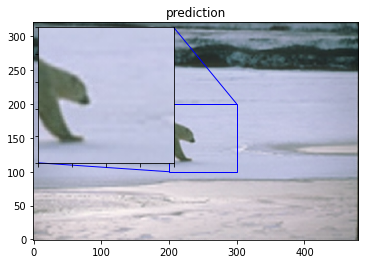

Epoch 102/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.35
Epoch 103/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.56
Epoch 104/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.51
Epoch 105/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.39
Epoch 106/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.39
Epoch 107/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.47
Epoch 108/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.38
Epoch 109/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.31
Epoch 110/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.22
Epoch 111/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0024
Mean PSNR for epoch: 26.25
Epoch 112/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0027
Mean PSNR for epoch: 25.72
Epoch 113/500
13/13 - 1s - loss: 0.0027 - val_loss: 0.

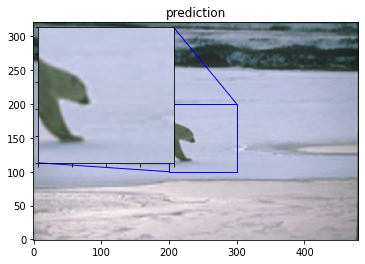

Epoch 122/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.39
Epoch 123/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.32
Epoch 124/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.39
Epoch 125/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.04
Epoch 126/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.60
Epoch 127/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.47
Epoch 128/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.73
Epoch 129/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.26
Epoch 130/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.36
Epoch 131/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.49
Epoch 132/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.44
Epoch 133/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.

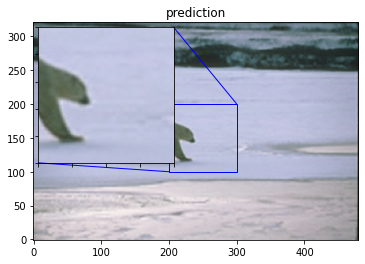

Epoch 142/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.43
Epoch 143/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.55
Epoch 144/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.61
Epoch 145/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0024
Mean PSNR for epoch: 26.41
Epoch 146/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.45
Epoch 147/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.39
Epoch 148/500
13/13 - 1s - loss: 0.0027 - val_loss: 0.0023
Mean PSNR for epoch: 26.54
Epoch 149/500
13/13 - 1s - loss: 0.0027 - val_loss: 0.0023
Mean PSNR for epoch: 26.52
Epoch 150/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0025
Mean PSNR for epoch: 26.04
Epoch 151/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.16
Epoch 152/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.42
Epoch 153/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.

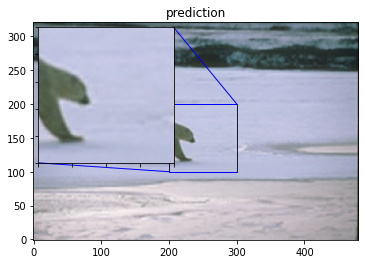

Epoch 162/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.38
Epoch 163/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.61
Epoch 164/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.51
Epoch 165/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.17
Epoch 166/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.30
Epoch 167/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.36
Epoch 168/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.48
Epoch 169/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0024
Mean PSNR for epoch: 26.32
Epoch 170/500
13/13 - 1s - loss: 0.0027 - val_loss: 0.0023
Mean PSNR for epoch: 26.27
Epoch 171/500
13/13 - 1s - loss: 0.0027 - val_loss: 0.0026
Mean PSNR for epoch: 25.78
Epoch 172/500
13/13 - 1s - loss: 0.0027 - val_loss: 0.0024
Mean PSNR for epoch: 26.31
Epoch 173/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.

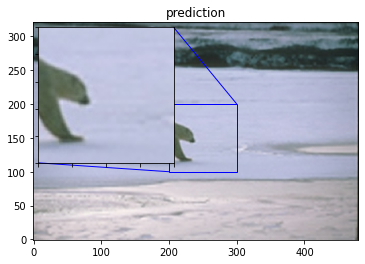

Epoch 182/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.29
Epoch 183/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.72
Epoch 184/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.53
Epoch 185/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.47
Epoch 186/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.21
Epoch 187/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.20
Epoch 188/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.45
Epoch 189/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.61
Epoch 190/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.33
Epoch 191/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0024
Mean PSNR for epoch: 26.43
Epoch 192/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.0023
Mean PSNR for epoch: 26.26
Epoch 193/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.

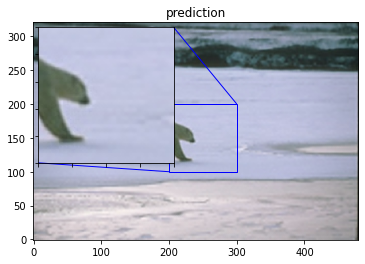

Epoch 202/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.36
Epoch 203/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.53
Epoch 204/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.52
Epoch 205/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.31
Epoch 206/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.46
Epoch 207/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.39
Epoch 208/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.38
Epoch 209/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0024
Mean PSNR for epoch: 26.58
Epoch 210/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.50
Epoch 211/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.47
Epoch 212/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.39
Epoch 213/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.

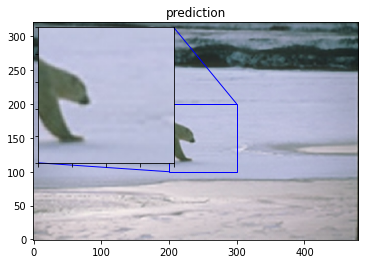

Epoch 222/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.59
Epoch 223/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.46
Epoch 224/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.63
Epoch 225/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.34
Epoch 226/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.18
Epoch 227/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.70
Epoch 228/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.35
Epoch 229/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.50
Epoch 230/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.22
Epoch 231/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.65
Epoch 232/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.29
Epoch 233/500
13/13 - 1s - loss: 0.0026 - val_loss: 0.

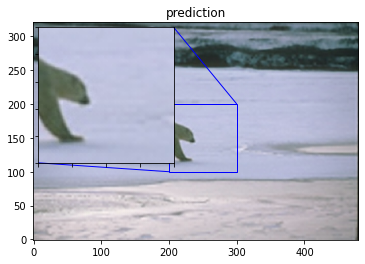

Epoch 242/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.62
Epoch 243/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.64
Epoch 244/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.91
Epoch 245/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.47
Epoch 246/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.54
Epoch 247/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.67
Epoch 248/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.40
Epoch 249/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.59
Epoch 250/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.38
Epoch 251/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.32
Epoch 252/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.51
Epoch 253/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.

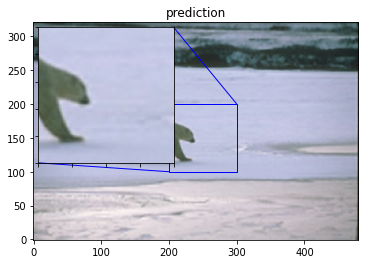

Epoch 262/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.71
Epoch 263/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.83
Epoch 264/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.38
Epoch 265/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.23
Epoch 266/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.22
Epoch 267/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.55
Epoch 268/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.60
Epoch 269/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.47
Epoch 270/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.53
Epoch 271/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.63
Epoch 272/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.45
Epoch 273/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.

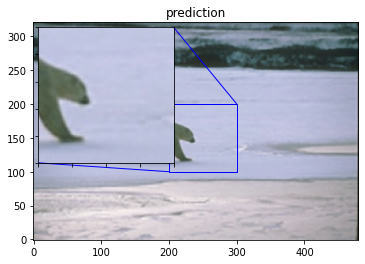

Epoch 282/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.49
Epoch 283/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.47
Epoch 284/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.50
Epoch 285/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.82
Epoch 286/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.32
Epoch 287/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.58
Epoch 288/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.69
Epoch 289/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0023
Mean PSNR for epoch: 26.63
Epoch 290/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.60
Epoch 291/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.48
Epoch 292/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.52
Epoch 293/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.

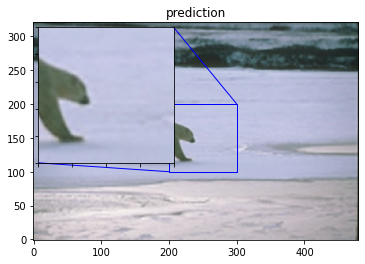

Epoch 302/500
13/13 - 1s - loss: 0.0024 - val_loss: 0.0022
Mean PSNR for epoch: 26.53
Epoch 303/500
13/13 - 1s - loss: 0.0024 - val_loss: 0.0022
Mean PSNR for epoch: 26.77
Epoch 304/500
13/13 - 1s - loss: 0.0024 - val_loss: 0.0022
Mean PSNR for epoch: 26.54
Epoch 305/500
13/13 - 1s - loss: 0.0024 - val_loss: 0.0022
Mean PSNR for epoch: 26.57
Epoch 306/500
13/13 - 1s - loss: 0.0024 - val_loss: 0.0022
Mean PSNR for epoch: 26.32
Epoch 307/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.63
Epoch 308/500
13/13 - 1s - loss: 0.0024 - val_loss: 0.0022
Mean PSNR for epoch: 26.62
Epoch 309/500
13/13 - 1s - loss: 0.0024 - val_loss: 0.0022
Mean PSNR for epoch: 26.58
Epoch 310/500
13/13 - 1s - loss: 0.0024 - val_loss: 0.0022
Mean PSNR for epoch: 26.47
Epoch 311/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.65
Epoch 312/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.0022
Mean PSNR for epoch: 26.70
Epoch 313/500
13/13 - 1s - loss: 0.0025 - val_loss: 0.

In [17]:
epochs = 500

opt_wedge = keras.optimizers.Adam(learning_rate=0.001)

model_wedge.compile(
    optimizer=opt_wedge, loss=loss_fn,
)

model_wedge.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)

loss = model_wedge.evaluate(valid_ds)
print(loss)
print('PSNR: ', psnr(loss))

PSNR of low resolution image and high resolution image is 29.8502
PSNR of predict and high resolution is 30.4590


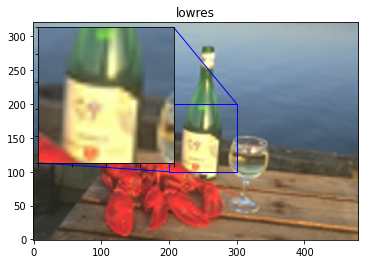

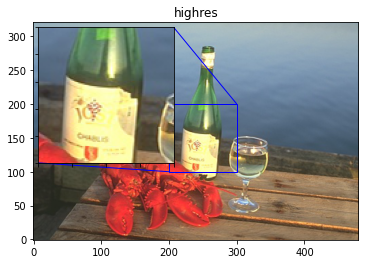

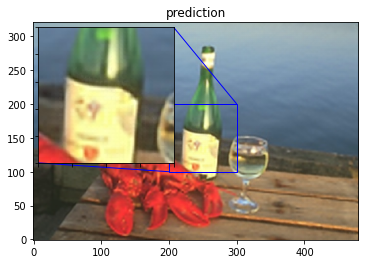

Avg. PSNR of lowres images is 2.9850
Avg. PSNR of reconstructions is 3.0459


In [19]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_paths[50:60]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model_wedge, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    )
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")
    break

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))